In [1]:
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
print(tf.__version__)

2.8.0


In [4]:
model = tf.keras.models.load_model("./GL_classification_model")
model.summary()

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_2 (Dense)             (None, 3)        

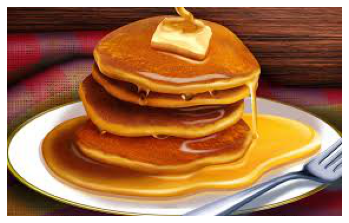

In [5]:
img = cv2.imread("./pancake.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis(False)
plt.imshow(img);

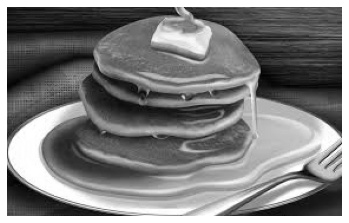

In [6]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.axis(False)
plt.imshow(gray_img, cmap = "gray");

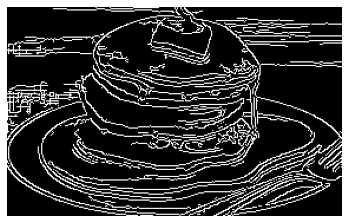

In [7]:
#detect edges
canny_img = cv2.Canny(gray_img, 50, 200)
plt.axis(False)
plt.imshow(canny_img, cmap = 'gray');

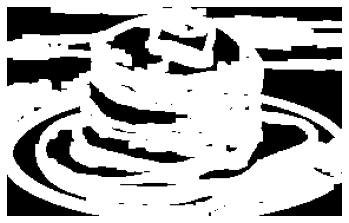

In [8]:
#smooth out the edges
kernel = np.ones((6, 6), np.uint8)
mask = cv2.dilate(canny_img , kernel, iterations = 1)
plt.axis(False)
plt.imshow(mask, cmap = "gray");

In [9]:
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [10]:
#find biggest contour
biggest_contour = None
biggest_area = 0
for contour in contours:
    area = cv2.contourArea(contour)
    if area > biggest_area:
        biggest_area = area
        biggest_contour = contour

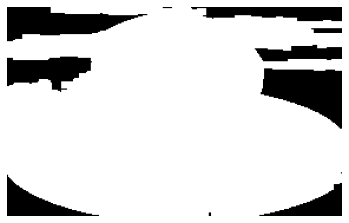

In [11]:
#mask the biggest contour over
crop_zero_mask = np.zeros_like(mask)
cv2.drawContours(crop_zero_mask, [biggest_contour], -1, (255), -1)
plt.axis(False)
plt.imshow(crop_zero_mask, cmap = "gray");

In [12]:
inverted_mask = cv2.bitwise_not(crop_zero_mask)

In [13]:
contours, _ = cv2.findContours(inverted_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [14]:
#detect smaller contours
small_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area < 1000:
        print(area)
        small_contours.append(contour)

2.0
708.5
894.5
0.0
637.0
69.5
979.5
0.0


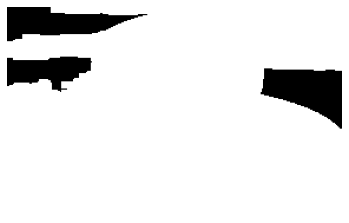

In [15]:
#mask smaller contour over the mask
cv2.drawContours(crop_zero_mask, small_contours, -1, (255), -1)
plt.axis(False)
plt.imshow(crop_zero_mask, cmap = "gray");

In [16]:
#remove background noise
crop_zero_mask = cv2.erode(crop_zero_mask, kernel, iterations = 1)
crop_zero_mask = cv2.dilate(crop_zero_mask, kernel, iterations = 1)
crop_zero_mask = cv2.medianBlur(crop_zero_mask, 5)

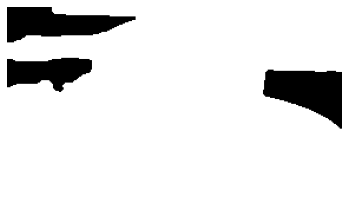

In [17]:
plt.axis(False)
plt.imshow(crop_zero_mask, cmap = "gray");

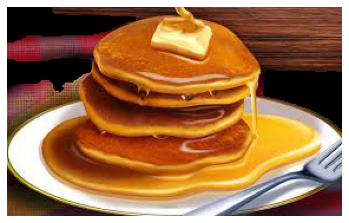

In [18]:
crop = np.zeros_like(img)
crop[crop_zero_mask == 255] = img[crop_zero_mask == 255]
plt.axis(False)
plt.imshow(crop, cmap = "gray");

In [19]:
CLASSES = ['Compostable', 'Landfill', 'Recyclables']

In [20]:
def convert_and_predict_image(images, img_shape = 224):
    
    img = tf.convert_to_tensor(images)
    img = tf.image.resize(img, [img_shape, img_shape])
    img = tf.cast(img, tf.float32)

    return img

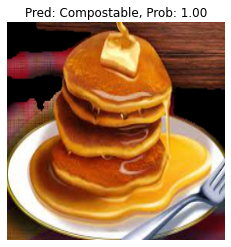

In [21]:
img = convert_and_predict_image(crop) 
pred_prob = model.predict(tf.expand_dims(img, axis=0)) #create a dimension 0 which is the batch size
pred_class = CLASSES[pred_prob.argmax()] 
plt.imshow(img/255.)
plt.title(f"Pred: {pred_class}, Prob: {pred_prob.max():.2f}", fontsize = 12)
plt.axis(False);